In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/IMDbmovies.csv')

# separate currency and amount into two new columns
df[['budget_currency','budget']] = df.budget.str.split(expand=True)
df[['box_office_currency','box_office']] = df.worlwide_gross_income.str.split(expand=True)
# convert amount string to numeric
df.budget = pd.to_numeric(df['budget'])
df.box_office = pd.to_numeric(df['box_office'])

df = df[df.budget_currency == "$"]

df = df[df.year > 1980]

df.shape

(12993, 25)

In [183]:
df.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics', 'budget_currency',
       'box_office_currency', 'box_office'],
      dtype='object')

In [232]:
df = df.drop(['imdb_title_id', 'title', 'original_title', 'date_published',
       'country', 'language', 'writer',
       'production_company', 'description', 'votes',
       'usa_gross_income', 'worlwide_gross_income',
       'reviews_from_users', 'reviews_from_critics', 'budget_currency','actors',
       'box_office_currency'], axis='columns')

In [234]:
df.head()

,year,genre,duration,director,avg_vote,budget,metascore,box_office
4115,2001,"Comedy, Fantasy, Romance",118,James Mangold,6.4,48000000.0,44.0,76019048.0
16550,1982,"Comedy, Crime, Drama",100,William Byron Hillman,4.9,1000000.0,NaN,NaN
18767,1982,"Horror, Thriller",96,Peter F. Buffa,4.6,1000000.0,NaN,NaN
19026,1981,"Adventure, Comedy, Fantasy",116,Terry Gilliam,7.0,5000000.0,79.0,42368025.0
19036,1981,Drama,90,Frederick King Keller,6.5,60000.0,NaN,NaN


We have full data for duration, avg_vote, budget, actors and director. For box_office we have data for about two thirds of our films. We should drop those as without box office figures as that is the point of this project. We only have metascore for about half of the films. Lets check how it correlates with user scores as found in avg_vote.

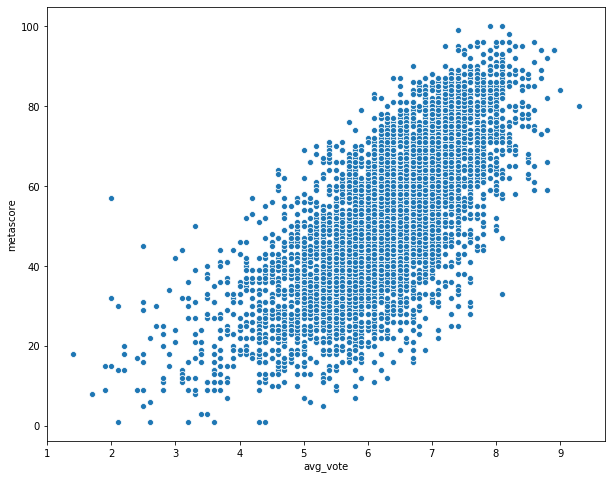

In [236]:
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x=df.avg_vote, y=df.metascore)

They look correlated but lets check the Peason correlation coefficient:

In [187]:
df.corr(method='pearson')

,year,duration,avg_vote,budget,metascore,box_office
year,1.000000,-0.051982,-0.143727,0.040693,-0.072699,0.113325
duration,-0.051982,1.000000,0.420261,0.361950,0.297710,0.269900
avg_vote,-0.143727,0.420261,1.000000,0.260110,0.727720,0.240850
budget,0.040693,0.361950,0.260110,1.000000,0.044075,0.757761
metascore,-0.072699,0.297710,0.727720,0.044075,1.000000,0.171702
box_office,0.113325,0.269900,0.240850,0.757761,0.171702,1.000000


The Pearson correlation coefficient between metascore and avg_vote is over 0.7 so this is high enough for us to just drop metascore. Even though there are differences between the way critics and regular people rate and enjoy films, the scores they give them are reasonably correlated. Some other interesting things to note are that metascore has almost no correlation with box_office - a film doesn't have to be good to make money. Also there is a strong correlation between budget and box_office - you have to spend money to make money.

In [237]:
df = df.drop(['metascore'], axis='columns')
df.rename(columns={'avg_vote':'score'})

,year,genre,duration,director,score,budget,box_office
4115,2001,"Comedy, Fantasy, Romance",118,James Mangold,6.4,48000000.0,76019048.0
16550,1982,"Comedy, Crime, Drama",100,William Byron Hillman,4.9,1000000.0,NaN
18767,1982,"Horror, Thriller",96,Peter F. Buffa,4.6,1000000.0,NaN
19026,1981,"Adventure, Comedy, Fantasy",116,Terry Gilliam,7.0,5000000.0,42368025.0
19036,1981,Drama,90,Frederick King Keller,6.5,60000.0,NaN
...,...,...,...,...,...,...,...
81234,2019,"Drama, Horror, Romance",122,Sitisiri Mongkolsiri,6.6,1200000.0,171229.0
81239,2019,Action,92,Keoni Waxman,4.8,3000000.0,NaN
81249,2019,Romance,92,Don Tjernagel,7.0,7000.0,NaN
81254,2019,Horror,77,"Robin Entreinger, Steve Noir",2.4,500000.0,NaN


So now the only na values are in box_office. Lets drop these as box_office is the target:

In [238]:
df = df.dropna()
df.shape

(8399, 7)

So we are left with over 8000 rows with which to build our model.

## Adjust for inflation

To compare movie budgets and box office numbers over the years we need to adjust for inflation. We will also drop films older than 1980 as the film industry has changed a lot over the years, and box office incomes from older films, even adjusted for inflation may not provide useful information. Also the vast majority of films are newer than this so not much is lost. I copied the information at https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/ to a csv:

In [240]:
cpi = pd.read_csv('./cpi.csv')
cpi

,Year,Jan,Feb,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec,Avg
0,1913,9.800,9.800,9.800,9.800,9.700,9.800,9.900,9.900,10.000,10.000,10.100,10.000,9.900
1,1914,10.000,9.900,9.900,9.800,9.900,9.900,10.000,10.200,10.200,10.100,10.200,10.100,10.000
2,1915,10.100,10.000,9.900,10.000,10.100,10.100,10.100,10.100,10.100,10.200,10.300,10.300,10.100
3,1916,10.400,10.400,10.500,10.600,10.700,10.800,10.800,10.900,11.100,11.300,11.500,11.600,10.900
4,1917,11.700,12.000,12.000,12.600,12.800,13.000,12.800,13.000,13.300,13.500,13.500,13.700,12.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525,237.017
103,2016,236.916,237.111,238.132,239.261,240.236,241.038,240.647,240.853,241.428,241.729,241.353,241.432,240.007
104,2017,242.839,243.603,243.801,244.524,244.733,244.955,244.786,245.519,246.819,246.663,246.669,246.524,245.120
105,2018,247.867,248.991,249.554,250.546,251.588,251.989,252.006,252.146,252.439,252.885,252.038,251.233,251.107


We just need rates since 1980 and we only care about the average for the whole year.

In [241]:
cols = cpi.columns[cpi.columns.isin(['Year', 'Avg'])]
cpi = cpi[cols]
cpi = cpi[cpi['Year'] >= 1980]

We want a factor for each year that we can use to calculate the adjusted amounts from. To calculate this we can use: 

$$
x_{2020} = x_{old} \times \frac{CPI_{2020}}{CPI_{old}}
$$


In [242]:
cpi_2020 = 260.2
factors = [np.round(cpi_2020/item, 3) for i, item in enumerate(cpi.Avg)]
cpi['factors'] = factors

Now we need to apply these factors to our monetary values in the data.

In [243]:
movie_factors = np.zeros(len(df))
movie_year = df.year

for i, valuei in enumerate(movie_year):
    for j, valuej in cpi.Year.items():
        if valuei == valuej:
            movie_factors[i] = cpi.factors[j]
            
new_budget = df.budget*movie_factors
df['new_budget'] = new_budget
new_box_office = df.box_office*movie_factors
df['new_box_office'] = new_box_office

Lets compare adjusted box office returns to original box office returns:

Text(0, 0.5, 'Box office returns')

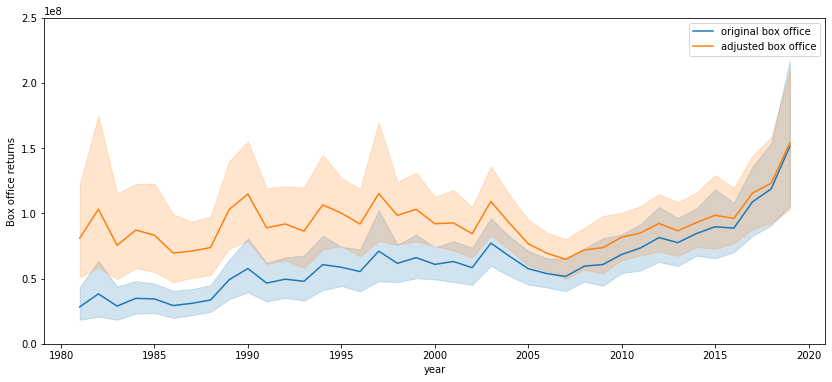

In [244]:
fig, ax = plt.subplots(figsize=(14,6))
ax.set_ylim(0, 2.5e8)
sns.lineplot(x=df.year, y=df.box_office, data=df, label="original box office")
sns.lineplot(x=df.year, y=df.new_box_office, data=df, label="adjusted box office")
ax.set_ylabel('Box office returns')

We can see that when adjusted for inflation, box office returns remained steady during the 80s and 90s, then dipped during the financial crash, and then have been rising ever since, with that rise accelerating in the last few years. Obviously this will have dropped in 2020 but our model should ignore the effects of the pandemic. Lets do the same for movie budgets:

Text(0, 0.5, 'Movie Budget')

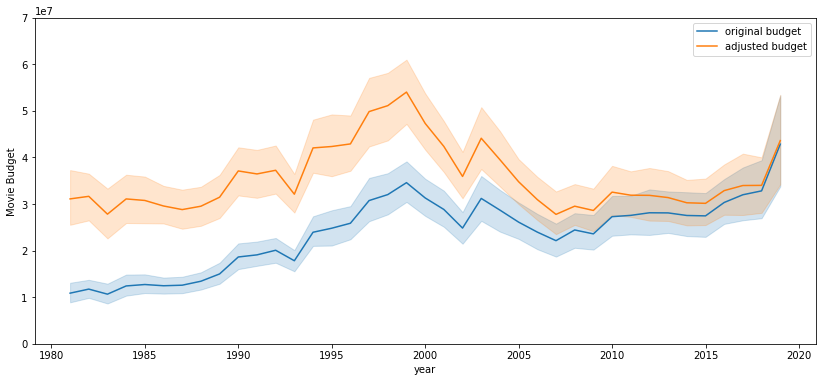

In [218]:
fig, ax = plt.subplots(figsize=(14,6))
ax.set_ylim(0, 7e7)
sns.lineplot(x=df.year, y=df.budget, data=df, label="original budget")
sns.lineplot(x=df.year, y=df.new_budget, data=df, label="adjusted budget")
ax.set_ylabel('Movie Budget')

Now we can drop year as we have no more use for it:

In [245]:
df = df.drop(['year','budget','box_office'], axis='columns')
df.rename(columns={'new_budget':'budget','new_box_office':'box_office'})

,genre,duration,director,avg_vote,budget,box_office
4115,"Comedy, Fantasy, Romance",118,James Mangold,6.4,70512000.0,1.116720e+08
19026,"Adventure, Comedy, Fantasy",116,Terry Gilliam,7.0,14310000.0,1.212573e+08
19090,"Drama, Romance, Thriller",116,Sydney Pollack,6.9,34344000.0,1.165319e+08
19096,"Comedy, Drama, Romance",87,Jean-Claude Tramont,5.6,40068000.0,1.274819e+07
19099,"Comedy, Horror",97,John Landis,7.5,28620000.0,8.747787e+07
...,...,...,...,...,...,...
80946,"Comedy, Family",96,Andy Fickman,4.5,30438200.0,2.218094e+07
80974,"Comedy, Drama, Family",121,Pankaj Batra,6.0,1003748.0,3.738198e+04
81059,Comedy,84,"Jon Lucas, Scott Moore",6.6,5090000.0,7.388561e+06
81234,"Drama, Horror, Romance",122,Sitisiri Mongkolsiri,6.6,1221600.0,1.743111e+05


In [246]:
df2 = df

## Genre

Lets investigate how the different genres perform. First we need to clean the genre data so that it can be used. Right now each film has one item in its genre value, which is a string with genres separated by commas. We can start by changing these to lists.

In [250]:
df2.genre = df2.genre.apply(lambda x: x.split(', '))

And then encoding the genre data so that the model can use it:

In [ ]:
df2 = df2.drop('genre', 1).join(df2.genre.str.join('|').str.get_dummies())

With this method each film can have more than one genre attached to it.

Let get a list of all the genres:

In [260]:
all_genres = []
for i in df.genre:
    for j in i:
        all_genres.append(j)
genres = np.array(all_genres)
unique_genres = np.unique(genres)

Text(0.5, 0, 'mean box office returns')

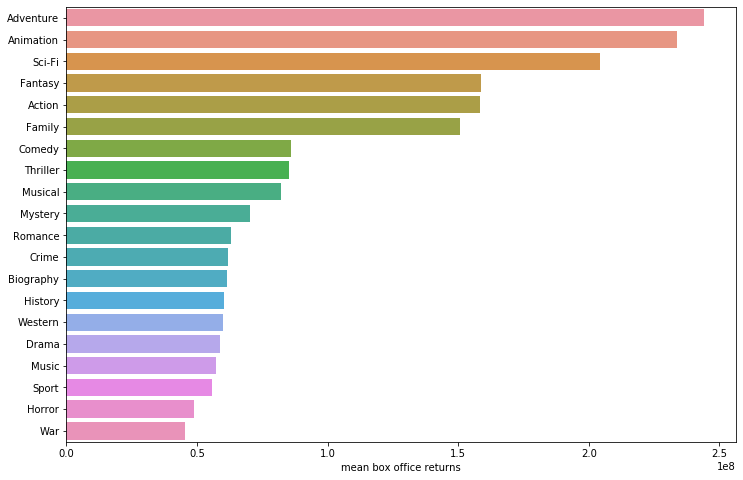

In [272]:
genre_boxoffice = []
for i in unique_genres:
    genre_boxoffice.append(np.mean(df2[df2[i] == 1].new_box_office))

genre_boxoffice = np.array(genre_boxoffice)

data = {'genre':  unique_genres,
        'mean': genre_boxoffice}

genre_boxoffice_data = pd.DataFrame(data, columns=['genre','mean'])

fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=1)
sns.barplot(x="mean",
            y="genre",
            data=genre_boxoffice_data,
            order=genre_boxoffice_data.sort_values('mean', ascending = False).genre
            )
plt.ylabel('')
plt.xlabel('mean box office returns')

The amount of money you can expect to make depends a lot on the genre you are working in. An action comedy is going to make more money than a western horror.